In [1]:
## Multi class classification with Linear SVC

In [1]:
import pandas as pd
import numpy as np
import scipy
from nltk.corpus import stopwords
import re
import os

In [2]:
## Loading Data - labelled data :

data_1 = pd.ExcelFile('R2_RNN_Tranzact_Rohan_1_Regrouped_with_supplier.xlsx')
tranzact_data_1 = data_1.parse(0)

## Loading Data - un-labelled data:

data_2 = pd.ExcelFile('14Mar_Gorky_.xlsx')
tranzact_data_new_1 = data_2.parse(0)


In [3]:
## Picking up required info from labelled data :

col = ['to_company_name', 'supplier_item_id.2', 'product', 'supplier']
tranzact_data_2 = tranzact_data_1[col]
tranzact_data_2.columns = ['OEM', 'item', 'product', 'supplier']

## Picking up required info from un-labelled data:

col = ['from_company_name', 'buyer_item_name', 'to_company_name']
tranzact_data_new_2 = tranzact_data_new_1[col]
tranzact_data_new_2.columns = ['OEM', 'item', 'supplier']

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from labelled Dat:

tranzact_data_cesare_international_1 = tranzact_data_2.loc[tranzact_data_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_2_revised = tranzact_data_2.drop(tranzact_data_cesare_international_1.index)
tranzact_data_cesare_international_1 = tranzact_data_cesare_international_1.reset_index(drop=True)
tranzact_data_2_revised = tranzact_data_2_revised.dropna() ## remove rows with cell value none
tranzact_data_2_revised = tranzact_data_2_revised.reset_index(drop=True)

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from unlabelled data :

tranzact_data_cesare_international_2 = tranzact_data_new_2.loc[tranzact_data_new_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_new_2_revised = tranzact_data_new_2.drop(tranzact_data_cesare_international_2.index)
tranzact_data_cesare_international_2 = tranzact_data_cesare_international_2.reset_index(drop=True)
tranzact_data_new_2_revised = tranzact_data_new_2_revised.dropna() ## remove rows with cell value none
tranzact_data_new_2_revised = tranzact_data_new_2_revised.reset_index(drop=True)


print('Labelled Data(tranzact_data_2_revised) = ', len(tranzact_data_2_revised))
print('Unlabelled Data(tranzact_data_new_2_revised) = ', len(tranzact_data_new_2_revised))
print('Bonetti International extracted frm labelled data = ', len(tranzact_data_cesare_international_1))
print('Bonetti International extracted frm un-labelled data = ', len(tranzact_data_cesare_international_2))


Labelled Data(tranzact_data_2_revised) =  11803
Unlabelled Data(tranzact_data_new_2_revised) =  11842
Bonetti International extracted frm labelled data =  1754
Bonetti International extracted frm un-labelled data =  5909


In [4]:
# Removing all 'Bonetti' & 'Waaree' supplier from both labelled and un-labelled data :

## First make Items in lower case and remove rows with any cell value = none :

tranzact_data_2_revised['item'] = tranzact_data_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2_revised['product'] = tranzact_data_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_2_revised['supplier'] = tranzact_data_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())

tranzact_data_new_2_revised['item'] = tranzact_data_new_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_new_2_revised['supplier'] = tranzact_data_new_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised = tranzact_data_new_2_revised.dropna() ## remove rows with cell value none

# Removing string 'bonetti' and 'waaree' from supplier :

supplier_bonetti_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('waaree')]
supplier_bonetti_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('waaree')]

tranzact_data_3 = tranzact_data_2_revised.drop(supplier_bonetti_2.index) # 'bonetti' removed
tranzact_data_3 = tranzact_data_3.drop(supplier_waaree_2.index)   # 'waaree' removed
tranzact_data_new_3 = tranzact_data_new_2_revised.drop(supplier_bonetti_2.index)
tranzact_data_new_3 = tranzact_data_new_3.drop(supplier_waaree_2.index)

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_new_3 = tranzact_data_new_3.reset_index(drop=True)

print(len(tranzact_data_3))
print(len(tranzact_data_new_3))

tranzact_data_new_3.head()


10546
10585


,OEM,item,supplier
0,Polfrost Air Con Pvt Ltd.,emerson liquid line filter/drier ek-165s (0476...,h j international
1,Nandan GSE Pvt Ltd,"hydraulic fittings - cramping nipple - 3/8"" x ...",asiatic hydraulics
2,Nandan GSE Pvt Ltd,hydraulic fitting - hose clip elbow 1/4 x 5/16,asiatic hydraulics
3,Nandan GSE Pvt Ltd,"hydraulic hose pipe - hose pipe 3/4"" x 500mm",asiatic hydraulics
4,Nandan GSE Pvt Ltd,"hydraulic hose pipe - hose pipe 3/4"" x 3 mtr 6...",asiatic hydraulics


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
# Merging two data frames :

tranzact_data_combined = pd.concat([tranzact_data_3, tranzact_data_new_3], axis=0, ignore_index=True)

# Removing duplicate (item + supplier) combinations :

tranzact_data_combined['find_duplicate'] = tranzact_data_combined['item'].map(str) + \
                                            tranzact_data_combined['supplier'].map(str)

tranzact_data_combined.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)

print(len(tranzact_data_combined))


20919


In [42]:
tranzact_data_combined['item'][20588]

'c.s circle gr is 2062 e250 a'

In [207]:
tranzact_data_combined.to_excel(r'/home/scar3crow/Downloads/2_test.xlsx')


In [261]:
   
print(tranzact_data_combined['item'][1])
print('===========================================')
print(tranzact_data_combined['item'][203])
print('+++++++++++++++++++++++++++++++++++++++++++')
print(tranzact_data_combined['item'][208])
print('*******************************************')
print(tranzact_data_combined['item'][225])
print('===========================================')
print(tranzact_data_combined['item'][3564:3571])


accumulator - model a-as 5126, (3/4" connection) - emerson make
rm sofn 218 open cover front (c.i. casting fg 260 - is 210-1993)
+++++++++++++++++++++++++++++++++++++++++++
rm sd 3148 bottom  (c.i. casting fg 260 - is 210-1993)
*******************************************
rm ssnld 520 top  (c.s. casting is 1030-1998 gr. 280/520)
3564      hex.bolt; 3/8"x16 unc,45l;is 1367gr8.8
3565    hex.bolt;3/8"x16unc;50l; is1367-2 gr.8.8
3566       hex.bolt; 3/8"x16 unc;55l;is1367gr8.8
3567      hex.bolt;5/8"x11unc;90l; is1367 gr.8.8
3568      hex.bolt; 7/16"x14 unc;45l;is1367gr8.8
3569      hex.bolt;1/2"x13unc;55l; is1367 gr.8.8
3570    hex bolt unc1/4"x20tpi,18l;1367 gr8.8,zp
Name: item, dtype: object


In [85]:

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'[.]', ' ')
#tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\^gr.$\rd+\b', 'gr')

print(tranzact_data_combined['item'][1])
print('===========================================')
print(tranzact_data_combined['item'][203])
print('+++++++++++++++++++++++++++++++++++++++++++')
print(tranzact_data_combined['item'][208])
print('*******************************************')
print(tranzact_data_combined['item'][225])
print('===========================================')
print(tranzact_data_combined['item'][5720])
print(tranzact_data_combined['item'][3564:3571])

print(type([tranzact_data_combined['item'][3564]]))
print([tranzact_data_combined['item'][3564]])
tranzact_data_combined.tail()

accumulator - model a-as 5126, (3/4" connection) - emerson make
rm sofn 218 open cover front (c i  casting fg 260 - is 210-1993)
+++++++++++++++++++++++++++++++++++++++++++
rm sd 3148 bottom  (c i  casting fg 260 - is 210-1993)
*******************************************
rm ssnld 520 top  (c s  casting is 1030-1998 gr  280/520)
key 6x6x40; en 8
3564      hex bolt; 3/8"x16 unc,45l;is 1367gr8 8
3565    hex bolt;3/8"x16unc;50l; is1367-2 gr 8 8
3566       hex bolt; 3/8"x16 unc;55l;is1367gr8 8
3567      hex bolt;5/8"x11unc;90l; is1367 gr 8 8
3568      hex bolt; 7/16"x14 unc;45l;is1367gr8 8
3569      hex bolt;1/2"x13unc;55l; is1367 gr 8 8
3570    hex bolt unc1/4"x20tpi,18l;1367 gr8 8,zp
Name: item, dtype: object
<class 'list'>
['hex bolt; 3/8"x16 unc,45l;is 1367gr8 8']


,OEM,item,product,supplier,find_duplicate
20914,R-Tech Products & Packaging Pvt Ltd,polybag 12x17 inch_pp,NaN,glory pack industries,polybag 12x17 inch_ppglory pack industries
20915,R-Tech Products & Packaging Pvt Ltd,polybag_10x15 inch_pp,NaN,glory pack industries,polybag_10x15 inch_ppglory pack industries
20916,CESARE BONETTI INDIA PVT. LTD.,"handle nut 1"" #600,htb,a194 gr8",NaN,shah brothers,"handle nut 1"" #600,htb,a194 gr8shah brothers"
20917,Entech Controls,round bar od50 astm a276 type 431,NaN,alpesh metals,round bar od50 astm a276 type 431alpesh metals
20918,R-Tech Products & Packaging Pvt Ltd,pp_monobox_st5,NaN,shree arun packaging co. pvt. ltd.,pp_monobox_st5shree arun packaging co. pvt. ltd.


In [86]:

is_list_1 = pd.DataFrame()
is_list_1['item'] = tranzact_data_combined['item'].str.findall(r'\is\s+\w+\b')
is_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\is\s+\w+\b')].index.values
print(is_list_index)
is_list = is_list_1[is_list_1.astype(str)['item'] != '[]']
is_list.tail()

[  185   186   187   188   189   190   191   192   193   194   195   196
   197   198   199   200   201   202   203   204   205   206   207   208
   218   225   226   243   244   260   261   262   263   282   283   284
   285   286   310   311   312   313   314   315   318   319   320   321
   322   323   324   325   326   327   328   481   482   484   485   510
   523   533   544   580   581   590   591  1303  1460  1461  1462  1813
  1814  1815  1816  1817  2066  2595  2612  2613  3564  3702  3758  3776
  3837  3838  3839  3840  3845  3896  3897  4051  4553  4554  4555  4556
  4557  4558  4559  4560  4561  5541  6040  7179  7180  7181  7182  7228
  7234  7235  7240  7241  7242  7852  7853  7862  7884  7885  7886  7887
  7888  7889  7890  7891  7892  7893  7894  7895  7896  8815  9415 10899
 10928 10929 10931 10932 10933 10934 10935 10936 10938 10939 10940 10941
 10942 10943 10944 10945 10946 10947 11088 11179 11182 11183 11656 11657
 11658 11928 11971 11972 11977 11978 12164 12539 12

,item
20200,[is 2016]
20205,[is 13638]
20343,[is 2062]
20588,[is 2062]
20685,[is as]


In [87]:
is_list['joined'] = is_list.item.apply(''.join)
is_list.tail()

,item,joined
20200,[is 2016],is 2016
20205,[is 13638],is 13638
20343,[is 2062],is 2062
20588,[is 2062],is 2062
20685,[is as],is as


In [88]:
is_list.joined = is_list.joined.str.replace(' ', '')
is_list.tail()

,item,joined
20200,[is 2016],is2016
20205,[is 13638],is13638
20343,[is 2062],is2062
20588,[is 2062],is2062
20685,[is as],isas


In [269]:
is_list.head()

,item,joined
185,[is 210],is210
186,[is 210],is210
187,[is 210],is210
188,[is 210],is210
189,[is 210],is210


In [82]:
print([tranzact_data_combined['item'][20588]])
aaa = [re.sub(r'\is\s+\w+\b', is_list['joined'][20588], a) for a in [tranzact_data_combined['item'][20588]]]

['c s circle gr is 2062 e250 a']


In [83]:
aaa

['c s circle gr is2062 e250 a']

In [89]:
for i in is_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\is\s+\w+\b', is_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]

In [94]:
print(tranzact_data_combined['item'][3564])

hex bolt; 3/8"x16 unc,45l;is1367gr8 8


In [ ]:
text = ['hanks_NNS sir_VBP', 'Oh_UH thanks_NNS to_TO remember_VB']
curated_text = [re.sub(r'_\S*', r'', a) for a in text]
print curated_text

In [23]:
tranzact_data_combined['item'].str.sub(r"\is\s+\w+\b", is_list['joined'][185])

AttributeError: 'StringMethods' object has no attribute 'sub'

In [48]:
print(type(tranzact_data_combined['item'][185]))
print(tranzact_data_combined['item'][185])

<class 'str'>
rm snh 616 top ( c i  casting grade: fg 260 - is 210, 1993)


In [55]:
for i in is_list_index:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\is\s+\w+\b', is_list['joined'][i])


In [68]:
for i in is_list_index:    
    tranzact_data_combined['item'][i] = tranzact_data_combined['item'][i].\
                                        replace(r'\is\s+\w+\b', is_list['joined'][i])
#print(tranzact_data_combined[item][185])

In [69]:
tranzact_data_combined['item'][20588]

'c s circle gr is 2062 e250 a'

In [67]:
tranzact_data_combined['item'] = tranzact_data_combined['item'].re.sub(r'\is\s+\w+\b', r'\1', regex=True)


AttributeError: 'Series' object has no attribute 're'

In [60]:
print(tranzact_data_combined['item'][185])
#print(tranzact[185])

None


In [103]:
index_is_2 = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\is\s+\w+\b')].index.values

is_list_2 = pd.DataFrame(tranzact_data_combined['item'].str.findall(r'\is\s+\w+\b'))
is_list_2['item'].replace('', np.nan, inplace=True)
#is_list = is_list_2.notnull()
is_list_2.dropna(subset=['item'], inplace=True)

print(type(index_is_2))
print(type(index_is_2.tolist()))
print(index_is_2)
print(is_list_2['item'][203:208])
print(is_list_2)
#print(''.join(is_list_2['item'][0].str.split()))


repl = lambda m: r'\is\w+'


tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\is\s+\w+', repl, regex = True)
print(tranzact_data_combined['item'][3564])

<class 'numpy.ndarray'>
<class 'list'>
[  185   186   187   188   189   190   191   192   193   194   195   196
   197   198   199   200   201   202   203   204   205   206   207   208
   218   225   226   243   244   260   261   262   263   282   283   284
   285   286   310   311   312   313   314   315   318   319   320   321
   322   323   324   325   326   327   328   481   482   484   485   510
   523   533   544   580   581   590   591  1303  1460  1461  1462  1813
  1814  1815  1816  1817  2066  2595  2612  2613  3564  3702  3758  3776
  3837  3838  3839  3840  3845  3896  3897  4051  4553  4554  4555  4556
  4557  4558  4559  4560  4561  5541  6040  7179  7180  7181  7182  7228
  7234  7235  7240  7241  7242  7852  7853  7862  7884  7885  7886  7887
  7888  7889  7890  7891  7892  7893  7894  7895  7896  8815  9415 10899
 10928 10929 10931 10932 10933 10934 10935 10936 10938 10939 10940 10941
 10942 10943 10944 10945 10946 10947 11088 11179 11182 11183 11656 11657
 11658 11928

In [164]:
index_is_2 = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\is\s+\w+\b')].index.values
#print(index_is_2)
is_list_2 = pd.DataFrame(tranzact_data_combined['item'].str.findall(r'\is\s+\w+\b'))

f = lambda x: ' '.join([item for item in x.split()])
#df["Locations"] = df["Locations"].apply(f)
tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\is\s+\w+\b', is_list_2[item].str.apply(f))


NameError: name 'item' is not defined

In [159]:
index_is_2 = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\is\s+\w+\b')].index.values
#print(index_is_2)
is_list_2 = pd.DataFrame(tranzact_data_combined['item'].str.findall(r'\is\s+\w+\b'))
print(is_list_2['item'][185][0].split())
#print('=====================')
#print(type(tranzact_data_combined))
#print(type(is_list_2))
#print(type(is_list_2[185]))
#print(is_list_2[185])
#print(is_list_2[185][0].split())
#print(type(index_is_2))
#print(index_is_2[0])

for i in index_is_2:
#    print(i)
#    print(is_list_2[i])
#    print(is_list_2[i][0].split())
#    aa = ''.join(is_list_2[i][0].split())
#    print(aa)
#    print(tranzact_data_combined['item'][i])

#    tranzact_data_combined['item'][i] = tranzact_data_combined['item'][i].\
#                                        replace(r'\is\s+\w+\b', ''.join(is_list_2[i][0].split()))
#    print(tranzact_data_combined['item'][i])
#    input('press enter')
    tranzact_data_combined['item'][i] = tranzact_data_combined['item'][i].\
                                        replace(r'\is\s+\w+\b', ''.join(is_list_2['item'][i][0].split()))
print(tranzact_data_combined['item'][185])

['is', '210']
rm snh 616 top ( c i  casting grade: fg 260 - is 210, 1993)


In [79]:
# Join words for en series, is series and gr series :

index_en = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\en\s+\w+\b')].index.values
index_is_1 = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\is\s+\w+\b')].index.values
index_is_2 = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\W\is\s+\w+\b')].index.values
index_gr = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\gr\s+\w+\b')].index.values
index_fg = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\fg\s+\w+\b')].index.values

en_list = tranzact_data_combined['item'].str.findall(r'\b\en\s+\w+\b')
is_list_1 = tranzact_data_combined['item'].str.findall(r'\b\is\s+\w+\b')
is_list_2 = tranzact_data_combined['item'].str.findall(r'\W\is\s+\w+\b')
gr_list = tranzact_data_combined['item'].str.findall(r'\b\gr\s+\w+\b')
fg_list = tranzact_data_combined['item'].str.findall(r'\b\fg\s+\w+\b')

for i in index_en:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\b\en\s+\w+\b', ''.join(en_list[i][0].split()))
for i in index_is_1:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\b\is\s+\w+\b', ''.join(is_list_1[i][0].split()))
for i in index_is_2:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\W\is\s+\w+\b', ''.join(is_list_2[i][0].split()))
for i in index_gr:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\b\gr\s+\w+\b', ''.join(gr_list[i][0].split()))
for i in index_fg:    
    tranzact_data_combined['item'] = tranzact_data_combined['item'].str.\
                                        replace(r'\b\fg\s+\w+\b', ''.join(fg_list[i][0].split()))


    
print(tranzact_data_combined['item'][1])
print('===========================================')
print(tranzact_data_combined['item'][203])
print('+++++++++++++++++++++++++++++++++++++++++++')
print(tranzact_data_combined['item'][208])
print('*******************************************')
print(tranzact_data_combined['item'][225])
print('===========================================')
print(tranzact_data_combined['item'][5720])
print(tranzact_data_combined['item'][3564:3571])

accumulator - model a-as 5126, (3/4" connection) - emerson make
rm sofn 218 open cover front (ci casting fg 260 - is210-1993)
+++++++++++++++++++++++++++++++++++++++++++
rm sd 3148 bottom  (ci casting fg 260 - is210-1993)
*******************************************
rm ssnld 520 top  (cs casting is210-1998 gr280/520)
key 6x6x40; en8
3564             hexbolt; 3/8"x16 unc,45l;is210
3565      hexbolt;3/8"x16unc;50l; is1367-2 gr88
3566        hexbolt; 3/8"x16 unc;55l;is1367gr88
3567        hexbolt;5/8"x11unc;90l; is1367 gr88
3568       hexbolt; 7/16"x14 unc;45l;is1367gr88
3569        hexbolt;1/2"x13unc;55l; is1367 gr88
3570    hex bolt unc1/4"x20tpi,18l;1367 gr88,zp
Name: item, dtype: object


In [180]:
tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b+\-\b+','')  
print(tranzact_data_combined['item'][5720])    
print(tranzact_data_combined['item'][225])    
print(tranzact_data_combined['item'][208])    
    
    
print(tranzact_data_combined['item'][1])    
print(tranzact_data_combined['item'][203])


error: nothing to repeat at position 2

In [25]:
## Join words :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.sub(r'\b\en\s+\d+\b', '\b\en|d+\b')

#tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\-\b','')  ## Join hyphaned words
#tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\d+\b','')  ## remove integers
#tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\W',' ')   ## remove puntuations

print(tranzact_data_combined['item'][5720:5726])


AttributeError: 'StringMethods' object has no attribute 'sub'

In [9]:
## cleaning the data

pd.options.mode.chained_assignment = None

l_ist = ['mm', 'ft']

## Join all hyphaned words :

tranzact_data_3['item'] = tranzact_data_3['item'].str.replace(r'\b+\-\b+','')  

## Removing underscores '_':

punctuation = ['_']

for i in punctuation:
    
    tranzact_data_3['item']= tranzact_data_3['item'].str.replace(i," ")

tranzact_data_3['feature'] = tranzact_data_3['item'].str.replace(r'\W',' ')   ## remove puntuations

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\d+\b','')  ## remove integers

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\d+\mm\b',' ')   ## remove all 'mm' dimensions 
 
tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\m\d+\b',' ') ## remove 'm8' etc

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\w\b','') ## remove stand alone single letters


tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

tranzact_data_3['feature']= tranzact_data_3['feature'].apply(lambda x:' '.join([i for i in x.split()
                                                                                if i not in l_ist]).lower())

## Removing only single word features :

tranzact_data_3 = tranzact_data_3[tranzact_data_3['feature'].str.contains(' ')]
tranzact_data_3 = tranzact_data_3.reset_index(drop=True)

## Final file for classification :

col_1 = ['product', 'feature', 'supplier']
tranzact_data = tranzact_data_3[col_1]

## Removing duplicate (item + supplier) combinations :

tranzact_data['find_duplicate'] = tranzact_data['feature'].map(str) + \
                                            tranzact_data['supplier'].map(str)

tranzact_data.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data = tranzact_data.reset_index(drop=True)


tranzact_data.tail()

,product,feature,supplier,find_duplicate
9921,cscasting,yoke casting gtv sa216 wcc qap,AMI Alloys,yoke casting gtv sa216 wcc qapAMI Alloys
9922,cscasting,yoke cast gtv sa216 wcc qap,Tulip Casting Pvt. Ltd.,yoke cast gtv sa216 wcc qapTulip Casting Pvt. ...
9923,alloysteelcasting,yoke casting gtv sa217 c12a qap,AMI Alloys,yoke casting gtv sa217 c12a qapAMI Alloys
9924,alloysteelcasting,yoke cast tcv a217wc6,RAJ ENGINEERS,yoke cast tcv a217wc6RAJ ENGINEERS
9925,cicasting,yoke sleeve gtv a439 d2,Waaree Industries Pvt.Ltd.,yoke sleeve gtv a439 d2Waaree Industries Pvt.Ltd.


In [10]:
# digitising 'product' and creating a dictionary :

tranzact_data['product_id'] = tranzact_data['product'].factorize()[0]

product_id_df = tranzact_data[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

tranzact_data.head()

,product,feature,supplier,find_duplicate,product_id
0,gas,new cylinder gas,Stallion Enterprises,new cylinder gasStallion Enterprises,0
1,cooling,accumulator model aas connection emerson make,Neelam Enterprises,accumulator model aas connection emerson makeN...,1
2,cooling,accumulator flokool psi fksa596,T J CONTROLS,accumulator flokool psi fksa596T J CONTROLS,1
3,cooling,accumulator connection,H J International,accumulator connectionH J International,1
4,cooling,accumulator 52167s,ANAND REFRIGERATION,accumulator 52167sANAND REFRIGERATION,1


1531


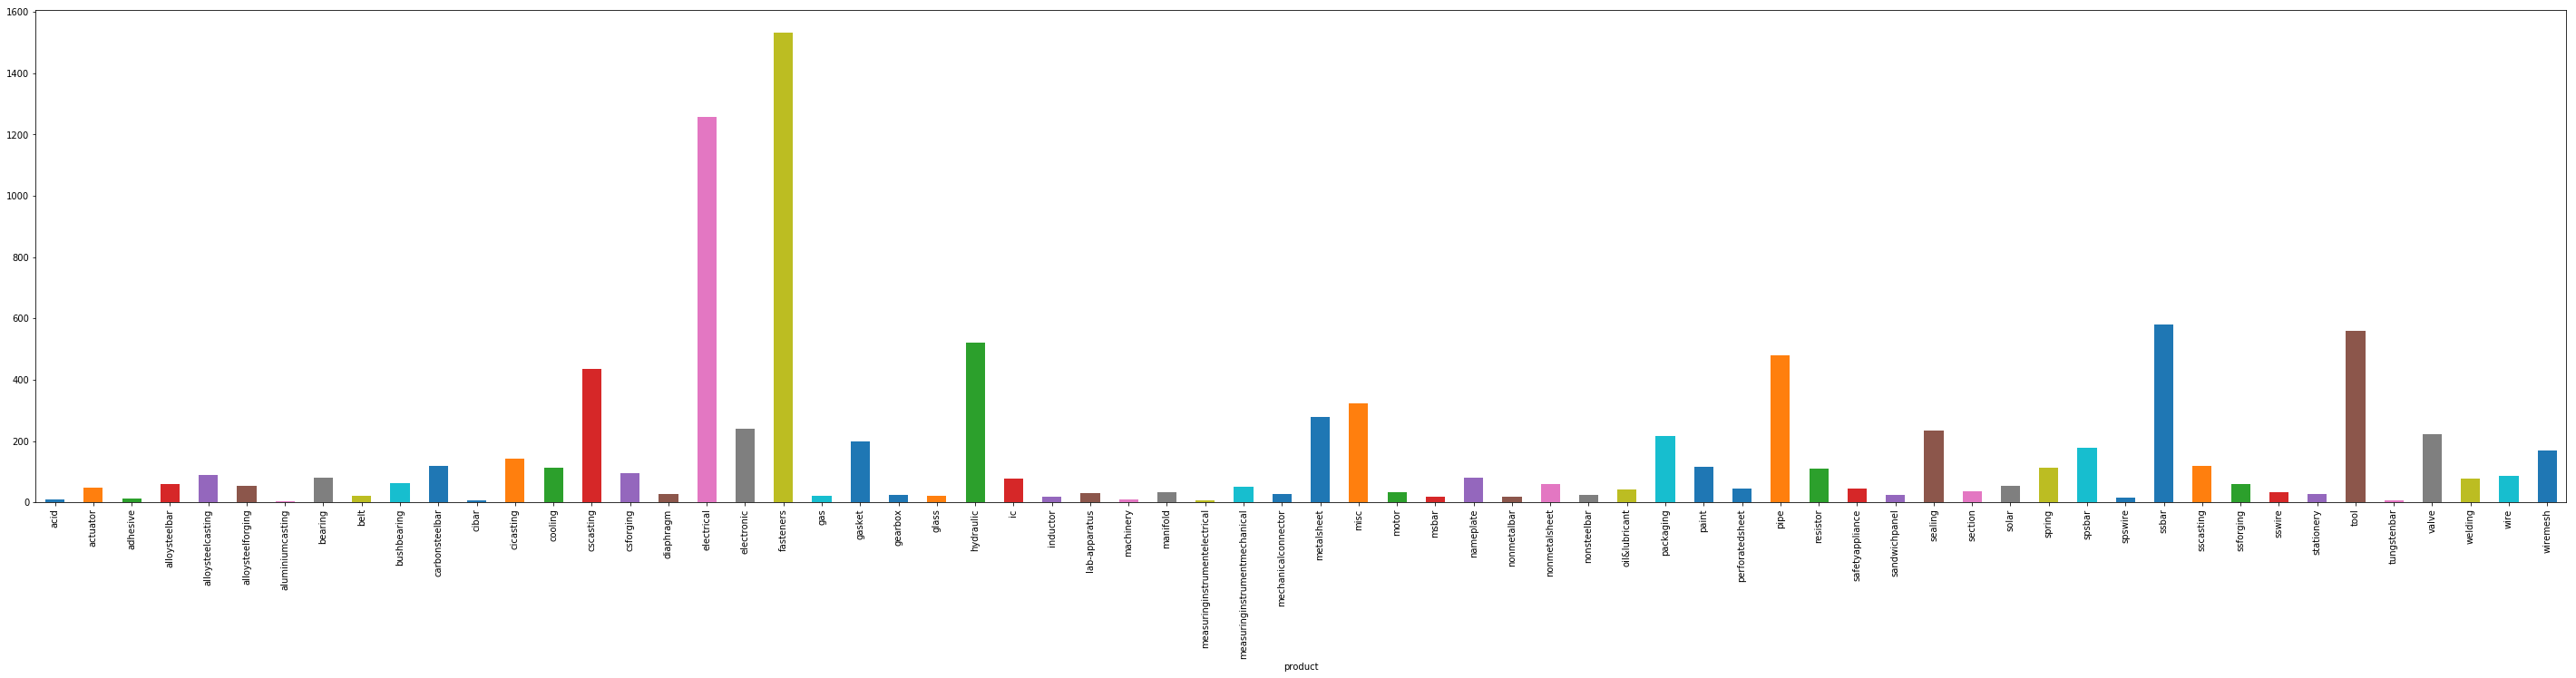

In [11]:
## To show distribution of product category

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(50,10))
print(max(tranzact_data.groupby('product').feature.count()))
tranzact_data.groupby('product').feature.count().plot.bar(ylim=0)
plt.show()

## Pl. note the unbalance distribution of product categories. In category Fasteners, there are 1736 items(maxm no.)

In [12]:
## Gives the product wise item distribution. In some product categories there are only 1 item.
from collections import Counter
Counter(tranzact_data["product"])

Counter({'acid': 9,
         'actuator': 48,
         'adhesive': 12,
         'alloysteelbar': 59,
         'alloysteelcasting': 89,
         'alloysteelforging': 55,
         'aluminiumcasting': 3,
         'bearing': 79,
         'belt': 22,
         'bushbearing': 62,
         'carbonsteelbar': 119,
         'cibar': 5,
         'cicasting': 142,
         'cooling': 113,
         'cscasting': 434,
         'csforging': 96,
         'diaphragm': 27,
         'electrical': 1257,
         'electronic': 240,
         'fasteners': 1531,
         'gas': 21,
         'gasket': 198,
         'gearbox': 24,
         'glass': 22,
         'hydraulic': 520,
         'ic': 78,
         'inductor': 19,
         'lab-apparatus': 31,
         'machinery': 10,
         'manifold': 33,
         'measuringinstrumentelectrical': 6,
         'measuringinstrumentmechanical': 51,
         'mechanicalconnector': 28,
         'metalsheet': 279,
         'misc': 323,
         'motor': 34,
         'msbar':

In [36]:
## Creating X and y variables for training. X = Items or item 'feature'. y = 'product' or product category

X = []
for i in range(tranzact_data.shape[0]):
    X.append(tranzact_data.iloc[i][1])
y = np.array(tranzact_data["product"])

print(X[1])


accumulator model aas connection emerson make


In [37]:
#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

print(X_train[1])
print(y_train[1])

sw end rubber cap
pipe


In [38]:
## Creating the pipeline for learning which include vectorizing and training with 
## Support Vector Classifier with Linear Kernel :

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), \
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)), \
                 ('clf', OneVsRestClassifier(LinearSVC(class_weight = 'balanced')))])

In [39]:
#fit model with training data

model.fit(X_train, y_train)

#evaluation on test data

pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

model_accuracy = accuracy_score(pred, y_test)

print(model_accuracy)


0.9415911379657603


In [187]:
## Input Item name here in the syntax given below :

Input_Item_Name = ['Insulator - GV2']

In [188]:
## Find product category here :
Output_Product_Category = model.predict(Input_Item_Name)
print('Product Category = ', Output_Product_Category)
output_cat_list = Output_Product_Category.tolist()


Product Category =  ['electrical']


In [72]:
## Saving the learned model :
from sklearn.externals import joblib

filename = 'svm_model.sav'
joblib.dump(model, filename)


['svm_model.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load(svm_model)

In [189]:
## creating data search file of all items of same category :

tranzact_data_search = tranzact_data.loc[tranzact_data['product'] \
                                                               == output_cat_list[0]]


tranzact_data_search = tranzact_data_search.reset_index(drop=True)
print(len(tranzact_data_search))
tranzact_data_search.head()

1257


,product,feature,supplier,find_duplicate,product_id
0,electrical,cable tie inch,GOLDLINK TECHNOCAST,cable tie inchGOLDLINK TECHNOCAST,19
1,electrical,way bar graph red face greay,ALPESH METALS,way bar graph red face greayALPESH METALS,19
2,electrical,led bar red lb714sr,Max Forge,led bar red lb714srMax Forge,19
3,electrical,batteries eveready,N M AUTOMATION AND CONTROL PRIVATE LIMITED,batteries evereadyN M AUTOMATION AND CONTROL P...,19
4,electrical,battery cr2032 3v,SUPERB AUTO BATTERIES,battery cr2032 3vSUPERB AUTO BATTERIES,19


In [190]:

from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', ngram_range=(1, 2), use_idf = True)
#digital_features = my_vectorizer.fit(tranzact_data_search['feature'])
#my_vector = digital_features.transform(tranzact_data_search['feature']).toarray()


## Creating test vector from Text features :

merge_text_feature = []
merge_text_feature_digit = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['feature'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

merge_text_feature_digit = my_vectorizer.fit(merge_text_feature)

# encode document
merge_digit_vector = merge_text_feature_digit.transform(merge_text_feature).toarray()


test_digit_vector = merge_digit_vector[len(merge_digit_vector)-1].reshape((merge_digit_vector.shape)[1],)

merge_digit_vector_1 = merge_digit_vector[0:(len(merge_digit_vector)-1)]

print(merge_digit_vector_1.shape)
print(test_digit_vector.shape)



(1257, 4956)
(4956,)


In [191]:
## Cosine Similarity :

def cos_cdist(matrix, vector):
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

## Finding cosine similarity & picking 50 top similar lines :

c_d = []

c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)

max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]
print(max_c_s_index)

[1082  881  815  810  816  814  813  420  756  747  419  746  751  253
  818  809  745  429  749  421  426  750  744  817  417  407  428  427
  401  402  425  403  404  405  406  408  418  415  409  424  410  411
  423  412  422  430  413  414  416 1256]


In [192]:
result = []
result_frame = []
max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

for i in max_c_s_index:
    
    result.append(np.array([c_d[i], tranzact_data_search['feature'][i], tranzact_data_search['supplier'][i]]))

result_frame = pd.DataFrame(result, columns=['c_index', 'feature', 'supplier'])

result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['supplier'])):
    if result_frame['c_index'][i] >= 0.10:
        print(result_frame['supplier'][i])
        kount = kount+1
        if kount == 5 :
            break
result_frame.head(10)

CESARE BONETTI INDIA PVT. LTD.
M/S. S. K. Enterprise
V Ramp Automation
AR BOTHRA INDUSTRIAL CORPORATION
PANTH ENTERPRISES


,c_index,feature,supplier
0,0.227,stator gv2,CESARE BONETTI INDIA PVT. LTD.
1,0.225,magnet gv2,M/S. S. K. Enterprise
2,0.219,insulator v2 v2,V Ramp Automation
3,0.203,downrod white gv2,AR BOTHRA INDUSTRIAL CORPORATION
4,0.194,canopy black gv2,PANTH ENTERPRISES
5,0.194,downrod ivory gv2,Tulip Casting Pvt. Ltd.
6,0.174,oc connector gv2,SPECTRA CONNECTRONICS LLP
7,0.167,c840 round insulator dmc,Vashi Electricals Pvt. Ltd
8,0.161,blade matte brown gv2,SHREYAS STEEL CORPORATION
9,0.161,downrod pearl white gv2,RADIO SERVICE ASSOCIATION


In [193]:
merge_text_feature = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['feature'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

max_length_merge = max([len(s.split()) for s in merge_text_feature])

In [194]:
print(max_length_merge)
merge_text_feature.head()

30


0                  cable tie inch
1    way bar graph red face greay
2             led bar red lb714sr
3              batteries eveready
4               battery cr2032 3v
dtype: object

In [195]:
from gensim.models import Word2Vec

from tqdm import tqdm

merge_text_feature = []
merge_digit_vector = []
test_digit_vector = []

merge_text_feature = tranzact_data_search['feature'].append(pd.Series(Input_Item_Name))

merge_text_feature = merge_text_feature.reset_index(drop=True)

temp_corpus = merge_text_feature.map(lambda x: x.split('.'))

corpus = []
for i in tqdm(range(len(temp_corpus))):
    for line in temp_corpus[i]:
        words = [x for x in line.split()]
        corpus.append(words)

100%|██████████| 1258/1258 [00:00<00:00, 52876.44it/s]


In [91]:
print(len(corpus[0]))

3


In [196]:
## items to word2vec :

emb_dim = 100

model_1 = Word2Vec(corpus, size = emb_dim, window=2, \
               min_count=1, negative = 15, iter = 15, workers = 10, sg=1)

vocab_size = len(model_1.wv.vocab)

print(vocab_size)

print(model_1)

1711
Word2Vec(vocab=1711, size=100, alpha=0.025)


In [197]:
from keras.preprocessing.text import Tokenizer

tokenizer_merge = Tokenizer()
tokenizer_merge.fit_on_texts(merge_text_feature)

max_length_merge = max([len(s.split()) for s in merge_text_feature])
                        
tokenizer_merge_index = tokenizer_merge.word_index

vocab_size_merge = len(tokenizer_merge_index)
print(tokenizer_merge_index)                        

{'sod523': 1047, 'graph': 673, 'fanuc': 682, 'mmx4core': 1209, 'tpwcapacitor': 849, 'coolig': 1194, 'marker': 291, 'id6mm': 602, 'bus': 1684, 'b48': 1244, 'p1212': 633, '45w': 1606, '2h': 1259, 'running': 499, 'adapter': 638, 'mic': 956, 'ul': 1580, '5mtr': 635, 'miscellaneous': 1498, 'bss138': 1331, '14s': 896, '12pf': 495, 'battery': 106, 'qevmetalwork': 41, 'systems': 594, '57a': 385, 'double': 723, 'florex': 1077, '1uf': 77, 'schneider': 195, 'al': 1242, '10ma': 743, 'shavison': 1436, 'id8mm': 603, 'cuttoff': 648, '600vac': 1338, 'mfs201': 1414, 'wago': 889, 'vj1206y102jxaac': 786, 'class': 360, 'current': 200, 'tantalum': 361, '1p': 1308, 'leaded': 93, 'electronic': 713, 'c840': 1263, '1kv': 182, 'sugar': 1150, 'three': 436, '25lg': 1393, 'sw': 519, '500w': 1442, 'core': 10, 'tracer': 350, 'cordtpw': 1346, 'zerocrossover5mmal': 1341, '2e': 585, 'copper': 22, 'epcos': 305, 'p2as2e3p': 1528, '10a': 227, 'to247ac': 1328, 'rv6': 1273, 'efd15h': 1106, 'sb': 1051, 'main': 378, 'do214ac2

In [134]:
print(vocab_size_merge)
print(len(merge_text_feature))
print(corpus[0][2])
print(model_1.wv.get_vector(corpus[0][0]))

1708
1258
inch
[ 0.00531422 -0.08740324 -0.08222257 -0.12899801 -0.15475085 -0.163057
  0.18513985 -0.36062765 -0.32775584 -0.04065453  0.3184027   0.3695678
 -0.5101895   0.03564022 -0.08278285  0.37450826 -0.12547307  0.20521249
 -0.12950574 -0.23542361 -0.04343544  0.18400235  0.02711576  0.15075897
 -0.03023637  0.42508173  0.351758   -0.11873965 -0.10947298 -0.15610208
 -0.43448284 -0.17689821 -0.2501244  -0.03748987 -0.06745612  0.10779626
  0.21494459  0.06624966  0.25569037 -0.11911091 -0.1880119   0.24927732
  0.08494496  0.05017168  0.10188263  0.11363015  0.07888637  0.11526236
 -0.27141827 -0.18781136  0.13344045 -0.01295647 -0.00898362  0.20055954
  0.01691925  0.06470533 -0.23988712  0.13110223 -0.05131466 -0.26941225
 -0.00082231  0.28596535 -0.07595673 -0.23382907 -0.08251759  0.05898278
 -0.31087568 -0.2450818   0.31771743  0.01451331 -0.06168523  0.11082708
  0.09837241 -0.03204493  0.2410294 ]


In [198]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
a = [1, 2, 3, 4, 5]
b = np.pad(a, (0,3), 'constant', constant_values=0)
print(b)
print(len(corpus[1]))

[1 2 3 4 5 0 0 0]
6


In [199]:
## Prepare matrix for co-sine similarity:

size_col = max_length_merge * emb_dim

embedding_matrix = np.zeros((len(merge_text_feature), emb_dim))

for i in range(len(merge_text_feature)):
    
    emb_mat = np.zeros((1, emb_dim*len(corpus[i])))
    emb_mat_col = emb_dim*len(corpus[i])
    
    emb_vector = np.zeros((len(corpus[i]), emb_dim))
    for j in range(len(corpus[i])):
        emb_vector[j] = model_1.wv.get_vector(corpus[i][j])
    
      
#    emb_mat = emb_vector.ravel()
    

#    embedding_matrix[i] = np.pad(emb_mat, (0, (size_col - emb_mat_col)), 'constant', constant_values = 0)
        
    embedding_matrix[i] = np.max(emb_vector, axis = 0)
    


        
print(embedding_matrix.shape)
        
#print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


(1258, 100)


In [125]:
print(embedding_matrix[0])

[ 0.03776038 -0.05264485 -0.09356659 ...  0.          0.
  0.        ]


In [200]:
test_digit_vector = embedding_matrix[len(embedding_matrix)-1].reshape((embedding_matrix.shape)[1],)

merge_digit_vector_1 = embedding_matrix[0:(len(embedding_matrix)-1)]

print(merge_digit_vector_1.shape)
print(test_digit_vector.shape)


(1257, 100)
(100,)


In [201]:
c_d = []

c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)

max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

result = []
result_frame = []
max_c_s_index = []
max_c_s_index = np.argsort(c_d)[-50:][::-1]

for i in max_c_s_index:
    
    result.append(np.array([c_d[i], tranzact_data_search['feature'][i], tranzact_data_search['supplier'][i]]))

result_frame = pd.DataFrame(result, columns=['c_index', 'feature', 'supplier'])

result_frame.c_index = result_frame.c_index.astype('float64')

result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
result_frame = result_frame.reset_index(drop=True)

kount = 0

for i in range(len(result_frame['supplier'])):
    if result_frame['c_index'][i] >= 0.10:
        print(result_frame['supplier'][i])
        kount = kount+1
        if kount == 5 :
            break
result_frame.head(10)

DAMODAR ENTERPRISES
Ankit Marketing Pvt. Ltd.
M/S. S. K. Enterprise
IDEAL RESOURCES PRODUTCS PVT. LTD.
A.M Steel Traders


,c_index,feature,supplier
0,1.000,solder iron 35w soldering bit,DAMODAR ENTERPRISES
1,1.000,solder iron 35w,Ankit Marketing Pvt. Ltd.
2,0.999,bottom insulator gv3,M/S. S. K. Enterprise
3,0.999,meanwell 24v smps rs2524,IDEAL RESOURCES PRODUTCS PVT. LTD.
4,0.999,chk coil 3uh 5a,A.M Steel Traders
5,0.999,resistor 100k,CESARE BONETTI INDIA PVT. LTD.
6,0.999,pin plug top 5a anchor,NEHA ENTERPRISES
7,0.999,speed regulator,PANTH ENTERPRISES
8,0.999,stator gv3,WAAREE INDUSTRIES PVT. LTD.
9,0.999,contactor 3tf31,Nemi Electricals
